### Import required packages and libraries

In [ ]:
import tensorflow as tf
import numpy as np
import cv2

print("TensorFlow:", tf.__version__)
print("NumPy:", np.__version__)
print("OpenCV:", cv2.__version__)
print("GPU Available:", tf.config.list_physical_devices('GPU'))

In [ ]:
# import system libs
import os
import time
import shutil
import pathlib
import itertools

# import data handling tools
import cv2
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import random
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

# import Deep learning Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adamax
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Activation, Dropout, BatchNormalization, GlobalAveragePooling2D
from tensorflow.keras.applications.mobilenet import preprocess_input
from tensorflow.keras.applications import MobileNet

# Ignore Warnings
import warnings
warnings.filterwarnings("ignore")

### Functions to Create Data Frame from Dataset

#### **Function to create data frame**

In [ ]:
# Generate data paths with labels
def define_paths(data_dir):
    filepaths = []
    labels = []

    folds = os.listdir(data_dir)
    for fold in folds:
        foldpath = os.path.join(data_dir, fold)
        filelist = os.listdir(foldpath)
        for file in filelist:
            fpath = os.path.join(foldpath, file)
            filepaths.append(fpath)
            labels.append(fold)

    return filepaths, labels


# Concatenate data paths with labels into one dataframe
def define_df(files, classes):
    Fseries = pd.Series(files, name= 'filepaths')
    Lseries = pd.Series(classes, name='labels')
    return pd.concat([Fseries, Lseries], axis= 1)

In [ ]:
def balance_and_split_data(data_dir):
    """
    1. Load image paths.
    2. Split into train, validation, test (80/10/10 stratified).
    3. Oversample (augment-based) the training set to make it class-balanced.
    """
    files, classes = define_paths(data_dir)
    df = define_df(files, classes)

    # Stratified split
    strat = df['labels']
    train_df, dummy_df = train_test_split(df, train_size=0.8, random_state=123, shuffle=True, stratify=strat)

    strat = dummy_df['labels']
    valid_df, test_df = train_test_split(dummy_df, train_size=0.5, random_state=123, shuffle=True, stratify=strat)

    # Find class distribution
    class_counts = train_df['labels'].value_counts()
    max_count = class_counts.max()

    print("Original training class distribution:\n", class_counts)

    # Oversample the training data
    oversampled_dfs = []
    for label, count in class_counts.items():
        subset = train_df[train_df['labels'] == label]
        sampled = subset.sample(max_count, replace=True, random_state=123)
        oversampled_dfs.append(sampled)

    train_balanced_df = pd.concat(oversampled_dfs).sample(frac=1, random_state=123).reset_index(drop=True)

    print("\nBalanced training class distribution:\n", train_balanced_df['labels'].value_counts())

    return train_balanced_df, valid_df, test_df

#### Function to generate images from dataframe

In [ ]:
def create_gens (train_df, valid_df, test_df, batch_size):
    '''
    This function takes train, validation, and test dataframe and fit them into image data generator, because model takes data from image data generator.
    Image data generator converts images into tensors. '''

    # define model parameters
    img_size = (224, 224)
    color = 'rgb'

    # use custom function for test data batch size
    ts_length = len(test_df)
    test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))

    # augmentation
    tr_gen = ImageDataGenerator(
        preprocessing_function=preprocess_input,
        rotation_range=40,
        width_shift_range=0.3,
        height_shift_range=0.3,
        zoom_range=0.3,
        horizontal_flip=True,
        brightness_range=[0.6, 1.4],
        shear_range=0.2,
        fill_mode='nearest'
    )

    ts_gen = ImageDataGenerator(preprocessing_function= preprocess_input)

    train_gen = tr_gen.flow_from_dataframe( train_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    valid_gen = ts_gen.flow_from_dataframe( valid_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= True, batch_size= batch_size)

    test_gen = ts_gen.flow_from_dataframe( test_df, x_col= 'filepaths', y_col= 'labels', target_size= img_size, class_mode= 'categorical',
                                        color_mode= color, shuffle= False, batch_size= test_batch_size)

    return train_gen, valid_gen, test_gen

#### **Function to display data sample**

In [ ]:
def show_images(gen):
    '''
    This function take the data generator and show sample of the images
    '''

    # return classes ,images to be displayed
    g_dict = gen.class_indices   
    classes = list(g_dict.keys())
    images, labels = next(gen)

    # calculate samples count to be displayed
    length = len(labels)        # length of batch size
    sample = min(length, 25)

    plt.figure(figsize= (20, 20))

    for i in range(sample):
        plt.subplot(5, 5, i + 1)
        image = (images[i] + 1) / 2  # convert from [-1,1] → [0,1] for plotting (for MobileNet)
        plt.imshow(image)
        index = np.argmax(labels[i])
        class_name = classes[index]
        plt.title(class_name, color= 'blue', fontsize= 12)
        plt.axis('off')
    plt.show()

#### **Callbacks**

In [ ]:
class CustomCallback(keras.callbacks.Callback):
    def __init__(self, patience, threshold, factor, batches, epochs):
        super(CustomCallback, self).__init__()
        self.patience = patience # specifies how many epochs without improvement before learning rate is adjusted
        self.threshold = threshold # specifies training accuracy threshold when lr will be adjusted based on validation loss
        self.factor = factor # factor by which to reduce the learning rate
        self.batches = batches # number of training batch to run per epoch
        self.epochs = epochs # total number of epochs for training

        # callback variables
        self.count = 0 # how many times lr been reduced without improvement
        self.stop_count = 0
        self.best_epoch = 1
        self.initial_lr = None
        self.highest_train_acc = 0 # initially set highest training accuracy to 0
        self.lowest_vloss = np.inf # initially set lowest validation loss to infinity
        self.best_weights = None
        self.initial_weights = None

    # Define method that runs when training begins
    def on_train_begin(self, logs= None):
        self.initial_lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        self.best_weights = self.model.get_weights()
        self.initial_weights = self.model.get_weights()

        msg = '{0:^8s}{1:^10s}{2:^9s}{3:^9s}{4:^9s}{5:^9s}{6:^9s}{7:^10s}{8:10s}{9:^8s}'.format('Epoch', 'Loss', 'Accuracy', 'V_loss', 'V_acc', 'LR', 'Next LR', 'Monitor','% Improv', 'Duration')
        print(msg)
        self.start_time = time.time()

    # Define method that runs when training ends
    def on_train_end(self, logs= None):
        stop_time = time.time()
        tr_duration = stop_time - self.start_time
        hours = tr_duration // 3600
        minutes = (tr_duration - (hours * 3600)) // 60
        seconds = tr_duration - ((hours * 3600) + (minutes * 60))

        msg = f'training elapsed time was {str(hours)} hours, {minutes:4.1f} minutes, {seconds:4.2f} seconds)'
        print(msg)

        # set model weights to best weights at end of training
        self.model.set_weights(self.best_weights)


    def on_train_batch_end(self, batch, logs= None):
        # get accuracy and loss for the batch
        acc = logs.get('accuracy') * 100
        loss = logs.get('loss')

        # prints over on the same line to show running batch count
        msg = '{0:20s}processing batch {1:} of {2:5s}-   accuracy=  {3:5.3f}   -   loss: {4:8.5f}'.format(' ', str(batch), str(self.batches), acc, loss)
        print(msg, '\r', end= '')


    def on_epoch_begin(self, epoch, logs= None):
        self.ep_start = time.time()


    # Define method runs on the end of each epoch
    def on_epoch_end(self, epoch, logs= None):
        ep_end = time.time()
        duration = ep_end - self.ep_start

        # get the current learning rate
        lr = float(tf.keras.backend.get_value(self.model.optimizer.learning_rate))
        current_lr = lr
        
        # log training and validation accuracy and loss
        acc = logs.get('accuracy')
        v_acc = logs.get('val_accuracy')
        loss = logs.get('loss')
        v_loss = logs.get('val_loss')

        if acc < self.threshold: # if training accuracy is below threshold adjust lr based on training accuracy
            monitor = 'accuracy'
            if epoch == 0:
                pimprov = 0.0
            else:
                pimprov = (acc - self.highest_train_acc ) * 100 / self.highest_train_acc # define improvement of model progress

            if acc > self.highest_train_acc: # check ig training accuracy improved in the epoch
                self.highest_train_acc = acc # set new highest training accuracy
                self.best_weights = self.model.get_weights() # training accuracy improved so save the weights
                self.count = 0 # set count to 0 since training accuracy improved
                self.stop_count = 0 # set stop counter to 0
                if v_loss < self.lowest_vloss:
                    self.lowest_vloss = v_loss
                self.best_epoch = epoch + 1  # set the value of best epoch for this epoch

            else:
                # training accuracy did not improve check if this has happened for patience number of epochs, if so adjust learning rate
                if self.count >= self.patience - 1: # lr should be adjusted
                    lr = lr * self.factor # adjust the learning by factor
                    # safely update learning rate regardless of type
                    try:
                        if hasattr(self.model.optimizer.learning_rate, "assign"):
                            self.model.optimizer.learning_rate.assign(lr)
                        else:
                            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                    except Exception:
                        # fallback for non-variable or legacy optimizers
                        self.model.optimizer.learning_rate = lr
                    self.count = 0 # reset the count to 0
                    self.stop_count = self.stop_count + 1 # count the number of consecutive lr adjustments
                    self.count = 0 # reset counter
                    if v_loss < self.lowest_vloss:
                        self.lowest_vloss = v_loss
                else:
                    self.count = self.count + 1 # increment patience counter

        else: # training accuracy is above threshold so adjust learning rate based on validation loss
            monitor = 'val_loss'
            if epoch == 0:
                pimprov = 0.0

            else:
                pimprov = (self.lowest_vloss - v_loss ) * 100 / self.lowest_vloss

            if v_loss < self.lowest_vloss: # check if validation loss improved
                self.lowest_vloss = v_loss # replace lowest validation loss with new validation loss
                self.best_weights = self.model.get_weights() # validation loss improved so save the weights
                self.count = 0 # reset count since validation loss improved
                self.stop_count = 0
                self.best_epoch = epoch + 1 # set the value of the best epoch to this epoch

            else: # validation loss did not improve
                if self.count >= self.patience - 1: # need to adjust lr
                    lr = lr * self.factor # adjust learning rate
                    self.stop_count = self.stop_count + 1 # increment stop counter since lr was adjusted
                    self.count = 0 # reset counter

                    # update learning rate
                    try:
                        if hasattr(self.model.optimizer.learning_rate, "assign"):
                            self.model.optimizer.learning_rate.assign(lr)
                        else:
                            tf.keras.backend.set_value(self.model.optimizer.learning_rate, lr)
                    except Exception:
                        # fallback for non-variable or legacy optimizers
                        self.model.optimizer.learning_rate = lr

                else:
                    self.count = self.count + 1 # increment the patience counter

                if acc > self.highest_train_acc:
                    self.highest_train_acc = acc

        msg = f'{str(epoch + 1):^3s}/{str(self.epochs):4s} {loss:^9.3f}{acc * 100:^9.3f}{v_loss:^9.5f}{v_acc * 100:^9.3f}{current_lr:^9.5f}{lr:^9.5f}{monitor:^11s}{pimprov:^10.2f}{duration:^8.2f}'
        print(msg)


#### **Function to plot history of training**

In [15]:
import numpy as np
import matplotlib.pyplot as plt

def plot_training(hist, save_path=None):
    '''
    This function takes training history and plots accuracy & losses with the best epochs.
    Optionally saves the figure if save_path is provided.
    '''

    # Extract metrics
    tr_acc = hist.history['accuracy']
    tr_loss = hist.history['loss']
    val_acc = hist.history['val_accuracy']
    val_loss = hist.history['val_loss']

    index_loss = np.argmin(val_loss)
    val_lowest = val_loss[index_loss]
    index_acc = np.argmax(val_acc)
    acc_highest = val_acc[index_acc]

    Epochs = [i+1 for i in range(len(tr_acc))]

    loss_label = f'best epoch= {index_loss + 1}'
    acc_label = f'best epoch= {index_acc + 1}'

    # Create figure
    plt.figure(figsize=(20, 8))
    plt.style.use('fivethirtyeight')

    # Loss plot
    plt.subplot(1, 2, 1)
    plt.plot(Epochs, tr_loss, 'r', label='Training loss')
    plt.plot(Epochs, val_loss, 'g', label='Validation loss')
    plt.scatter(index_loss + 1, val_lowest, s=150, c='blue', label=loss_label)
    plt.title('Training and Validation Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    # Accuracy plot
    plt.subplot(1, 2, 2)
    plt.plot(Epochs, tr_acc, 'r', label='Training Accuracy')
    plt.plot(Epochs, val_acc, 'g', label='Validation Accuracy')
    plt.scatter(index_acc + 1, acc_highest, s=150, c='blue', label=acc_label)
    plt.title('Training and Validation Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.tight_layout()

    # Save if path is provided
    if save_path:
        plt.savefig(save_path, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {save_path}")

    plt.show()


# **Model Structure**

#### **Start Reading Dataset**

In [ ]:
data_dir = 'path/to/dataset'  # Update this path accordingly

try:
    # Get splitted data
    train_df, valid_df, test_df = balance_and_split_data(data_dir)

    # Get Generators
    batch_size = 40
    train_gen, valid_gen, test_gen = create_gens(train_df, valid_df, test_df, batch_size)

except:
    print('Invalid Input')

Original training class distribution:
 labels
Potato___Early_blight    800
Potato___Late_blight     800
Potato___healthy         121
Name: count, dtype: int64

Balanced training class distribution:
 labels
Potato___Late_blight     800
Potato___healthy         800
Potato___Early_blight    800
Name: count, dtype: int64
Found 2400 validated image filenames belonging to 3 classes.
Found 215 validated image filenames belonging to 3 classes.
Found 216 validated image filenames belonging to 3 classes.


# Visualize Class distribution in Train data

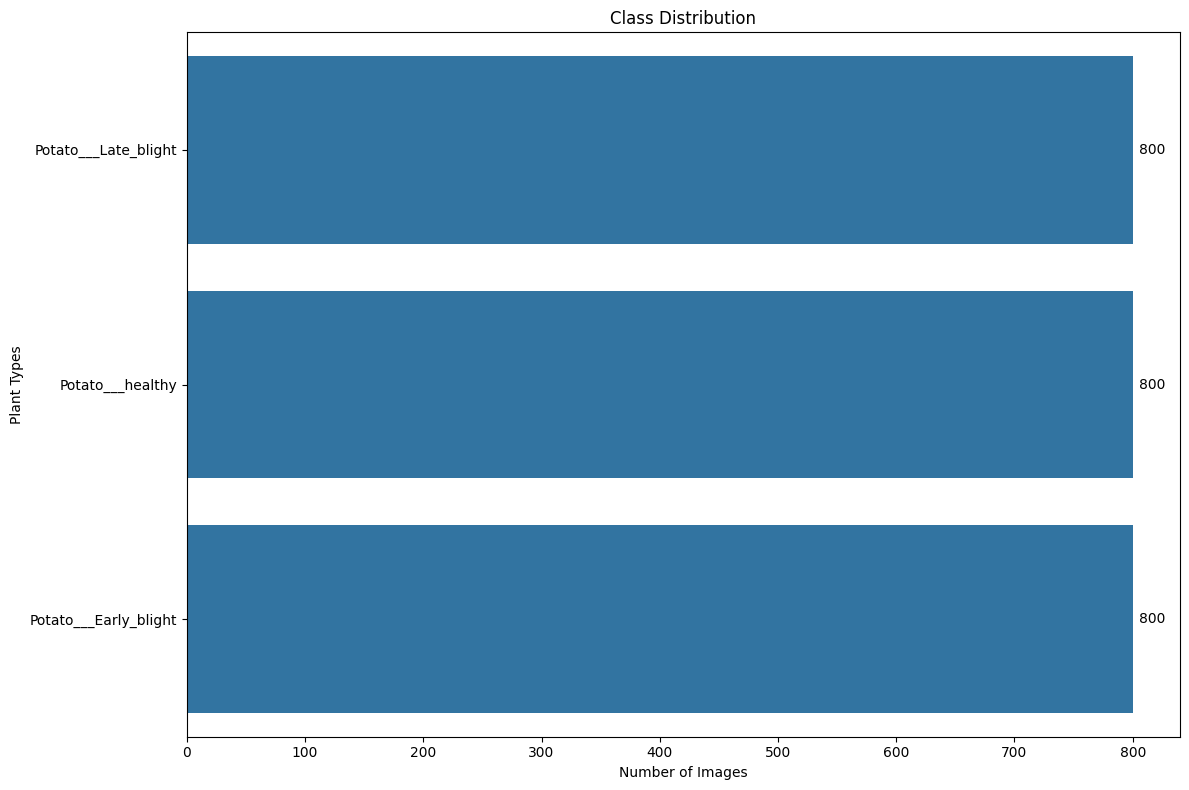

In [17]:
class_counts = train_df['labels'].value_counts() # train data class distribution
plt.figure(figsize=(12, 8))
ax = sns.barplot(x=class_counts.values, y=class_counts.index, orient='h')
plt.title('Class Distribution')
plt.xlabel('Number of Images')
plt.ylabel('Plant Types')
plt.tight_layout()  # Adjust the layout to prevent overlapping labels

# Add data labels to each bar
for i, v in enumerate(class_counts.values):
    ax.text(v + 5, i, str(v), color='black', va='center')

plt.show()

#### **Display Image Sample**

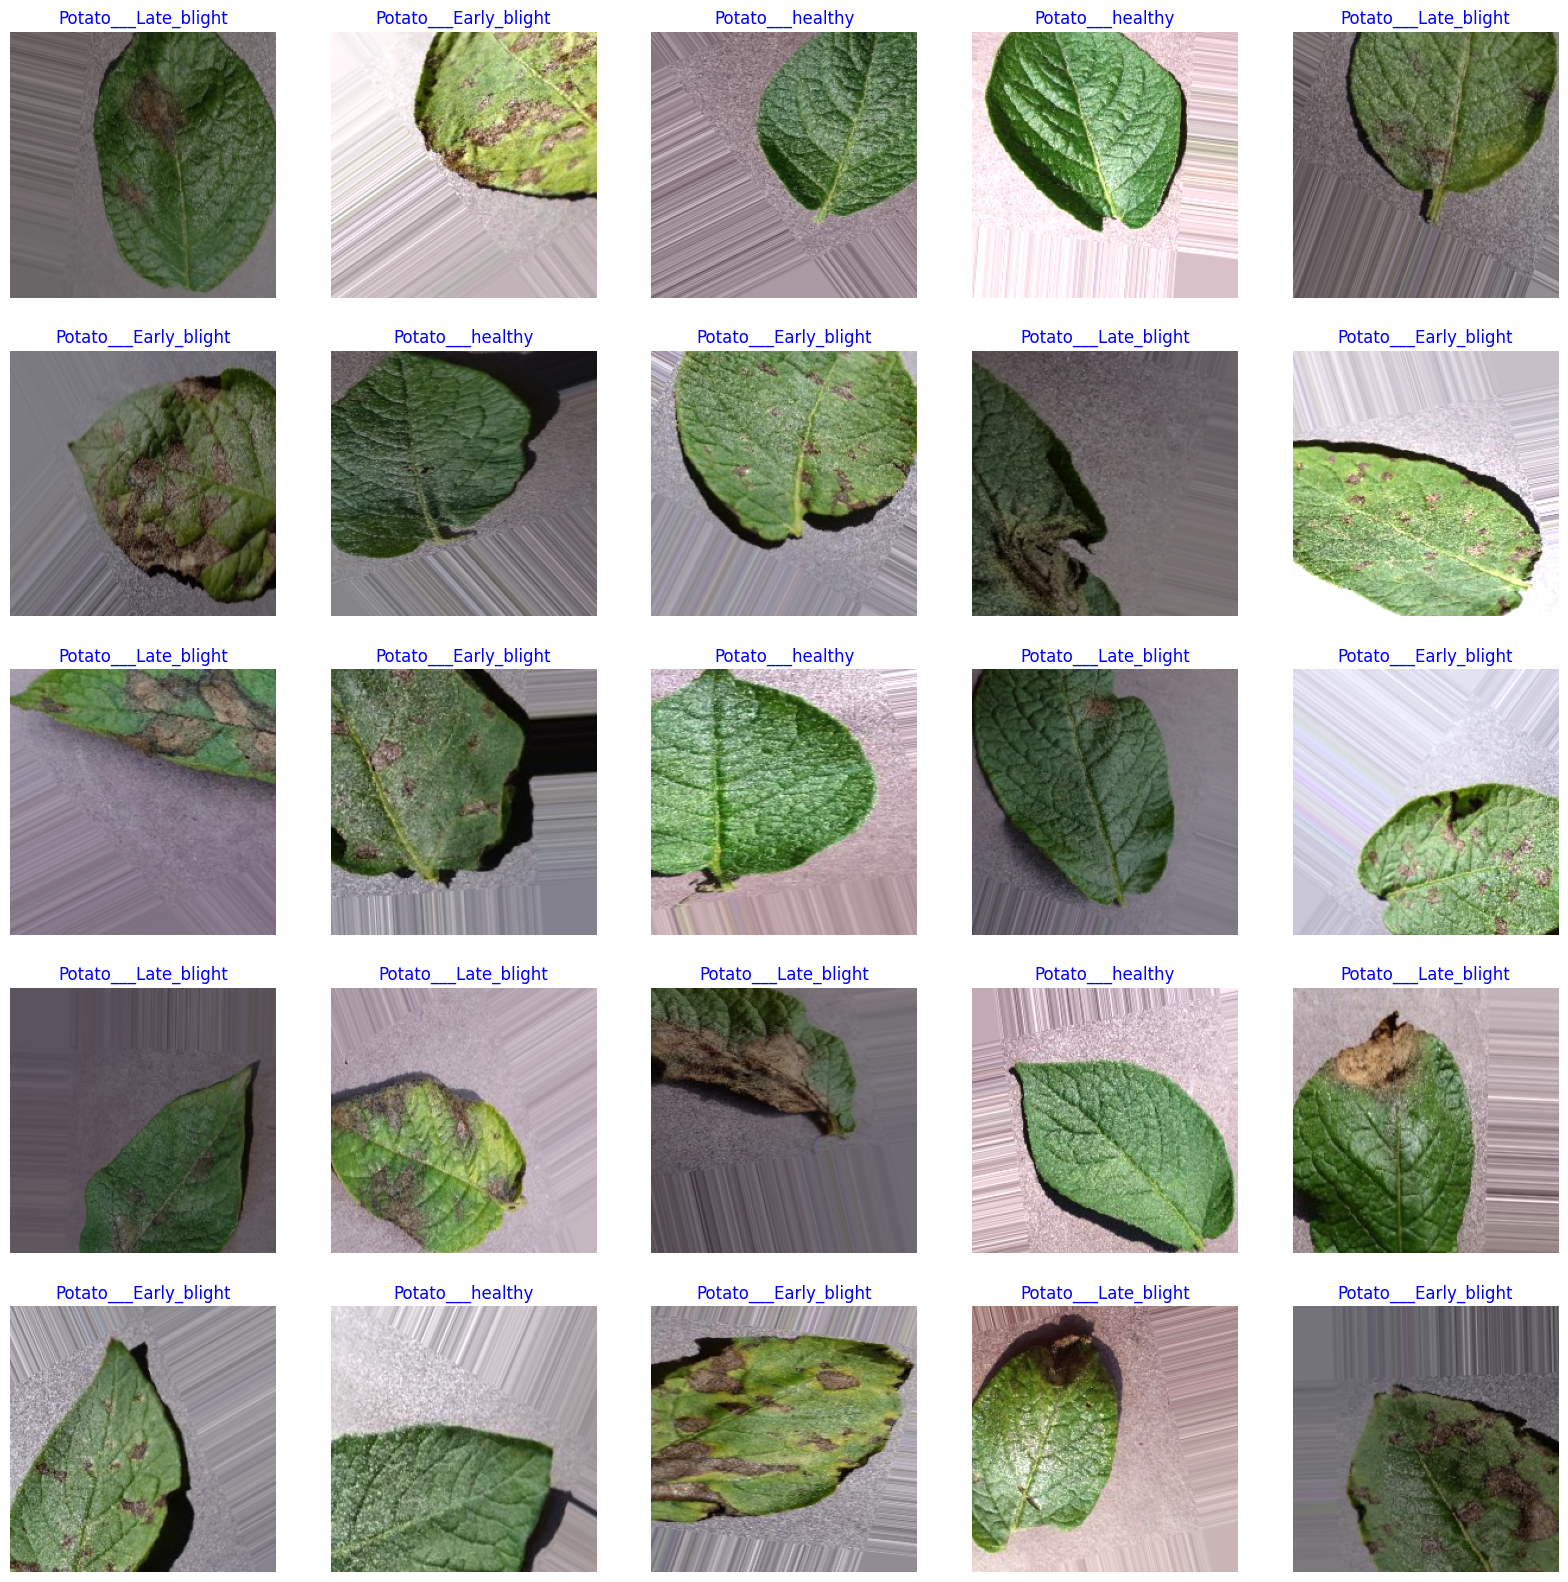

In [18]:
show_images(train_gen) # example of train data images with thier corresponding images

#### **Generic Model Creation**

In [ ]:
# Define input shape and number of classes
img_size = (224, 224)
channels = 3
img_shape = (img_size[0], img_size[1], channels)
class_count = 3

# Load MobileNet base
mobile = MobileNet(input_shape=img_shape, include_top=False, weights='imagenet')

# Build custom head with gradual compression
x = mobile.get_layer('conv_pw_13_relu').output
x = GlobalAveragePooling2D()(x)  # Replaces Flatten to reduce dimensionality
x = Dropout(0.5)(x)
x = Dense(512, activation='relu')(x)
x = Dropout(0.3)(x)
x = Dense(256, activation='relu')(x)
x = Dropout(0.2)(x)
output = Dense(units=class_count, activation='softmax')(x)

# Create final model
model = Model(inputs=mobile.input, outputs=output)

# Freeze early layers (all except last 23) starting from conv_pw_10 last layers are trainable
for layer in model.layers[:-23]:
    layer.trainable = False

# Compile
model.compile(optimizer=tf.keras.optimizers.Adamax(learning_rate=0.001),
              loss='categorical_crossentropy',
              metrics=['accuracy'])

# Summary
model.summary()

I0000 00:00:1762614712.411320 3893663 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 31141 MB memory:  -> device: 0, name: Tesla V100-SXM2-32GB, pci bus id: 0000:62:00.0, compute capability: 7.0


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1 (Conv2D)                  │ (None, 112, 112, 32)   │           864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_bn (BatchNormalization)   │ (None, 112, 112, 32)   │           128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1_relu (ReLU)               │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1 (DepthwiseConv2D)     │ (None, 112, 112, 32)   │           288 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_bn                    │ (None, 112, 112, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_1_relu (ReLU)           │ (None, 112, 112, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1 (Conv2D)              │ (None, 112, 112, 64)   │         2,048 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_bn                    │ (None, 112, 112, 64)   │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_1_relu (ReLU)           │ (None, 112, 112, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pad_2 (ZeroPadding2D)      │ (None, 113, 113, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2 (DepthwiseConv2D)     │ (None, 56, 56, 64)     │           576 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_bn                    │ (None, 56, 56, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_2_relu (ReLU)           │ (None, 56, 56, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2 (Conv2D)              │ (None, 56, 56, 128)    │         8,192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_2_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3 (DepthwiseConv2D)     │ (None, 56, 56, 128)    │         1,152 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_dw_3_relu (ReLU)           │ (None, 56, 56, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3 (Conv2D)              │ (None, 56, 56, 128)    │        16,384 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv_pw_3_bn                    │ (None, 56, 56, 128)    │           512 │
│ (BatchNormalization)            │                        │             

 Total params: 3,885,763 (14.82 MB)

 Trainable params: 2,513,923 (9.59 MB)

 Non-trainable params: 1,371,840 (5.23 MB)

#### **Set Callback Parameters**

In [ ]:
batch_size = 40 # set batch size for training
epochs = 10 # number of all epochs in training
patience = 1 # number of epochs to wait to adjust learning rate if does not improve
threshold = 0.9 # if train accuracy less than threshold target accuracy, else targets validation loss
factor = 0.5 # factor to reduce the learning rate
batches = int(np.ceil(len(train_gen.labels) / batch_size)) # number of training batches to run per epoch

callbacks = [CustomCallback(patience=patience, threshold=threshold, factor=factor, batches=batches, epochs=epochs)]

#### **Train model**

In [ ]:
history = model.fit(x= train_gen, epochs=10, verbose=0, callbacks=callbacks,
                    validation_data=valid_gen, validation_steps=None, shuffle=False)

 Epoch     Loss   Accuracy  V_loss    V_acc     LR     Next LR  Monitor  % Improv  Duration
 1 /10     0.330   87.833   4.63916  20.000   0.00100  0.00100  accuracy     0.00    52.48  
 2 /10     0.104   96.000   0.72783  76.744   0.00100  0.00100  val_loss    84.31    55.46  
 3 /10     0.085   97.333   0.18391  93.953   0.00100  0.00100  val_loss    74.73    40.79  
 4 /10     0.071   97.792   0.12201  94.419   0.00100  0.00100  val_loss    33.66    26.55  
 5 /10     0.057   98.208   0.02407  98.605   0.00100  0.00100  val_loss    80.27    26.49  
 6 /10     0.042   98.333   0.08128  96.279   0.00100  0.00050  val_loss   -237.65   25.91  
 7 /10     0.035   98.625   0.02420  99.070   0.00050  0.00025  val_loss    -0.54    25.82  
 8 /10     0.036   98.667   0.02063  99.070   0.00025  0.00025  val_loss    14.28    25.72  
 9 /10     0.035   98.750   0.03437  99.070   0.00025  0.00013  val_loss    -66.56   41.29  
10 /10     0.031   98.792   0.03662  99.070   0.00013  0.00006  val_los

#### **Display model performance**

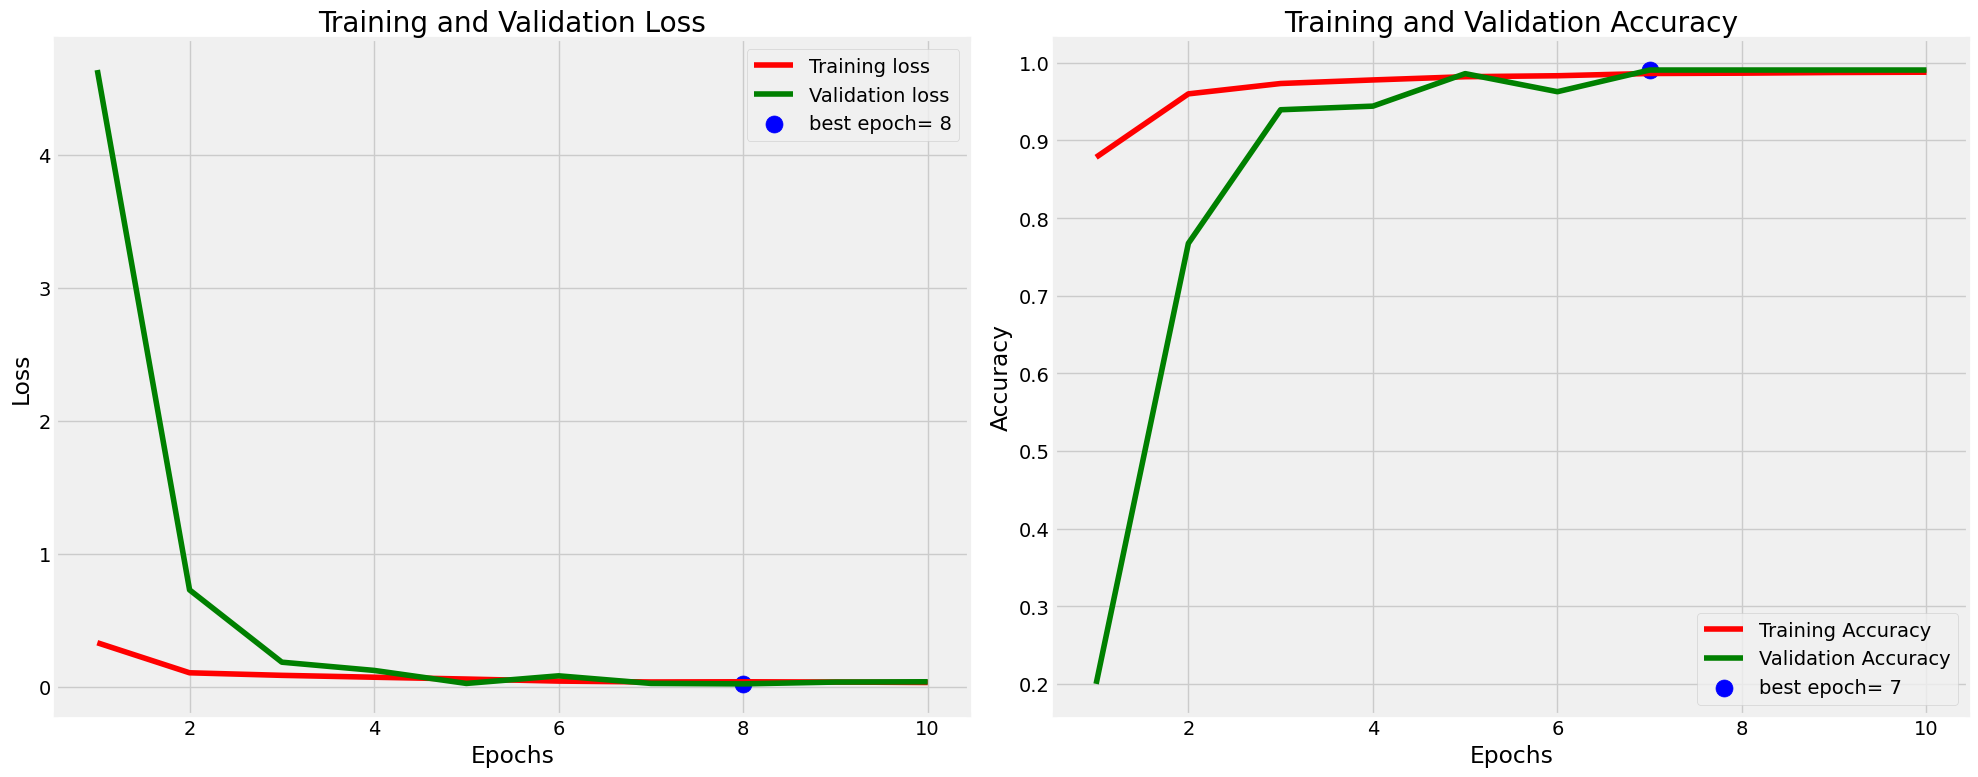

In [24]:
plot_training(history)

# **Evaluate model**

In [25]:
ts_length = len(test_df)
test_batch_size = test_batch_size = max(sorted([ts_length // n for n in range(1, ts_length + 1) if ts_length%n == 0 and ts_length/n <= 80]))
test_steps = ts_length // test_batch_size

train_score = model.evaluate(train_gen, steps= test_steps, verbose= 1)
valid_score = model.evaluate(valid_gen, steps= test_steps, verbose= 1)
test_score = model.evaluate(test_gen, steps= test_steps, verbose= 1)

print("Train Loss: ", train_score[0])
print("Train Accuracy: ", train_score[1])
print('-' * 20)
print("Validation Loss: ", valid_score[0])
print("Validation Accuracy: ", valid_score[1])
print('-' * 20)
print("Test Loss: ", test_score[0])
print("Test Accuracy: ", test_score[1])

3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 416ms/step - accuracy: 0.9688 - loss: 0.0667
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step - accuracy: 0.9865 - loss: 0.0358
3/3 ━━━━━━━━━━━━━━━━━━━━ 4s 700ms/step - accuracy: 1.0000 - loss: 0.0056
Train Loss:  0.058545470237731934
Train Accuracy:  0.9750000238418579
--------------------
Validation Loss:  0.023585718125104904
Validation Accuracy:  0.9916666746139526
--------------------
Test Loss:  0.006077993661165237
Test Accuracy:  1.0


#### **Confusion Matrics and Classification Report**

In [ ]:
# Step 1: Get predictions
pred_probs = model.predict(test_gen, steps=test_steps, verbose=1)
y_pred = np.argmax(pred_probs, axis=1)

# Step 2: Get true labels
y_true = test_gen.classes  # assumes test_gen is a flow_from_directory generator

# Step 3: Get class labels
class_labels = list(test_gen.class_indices.keys())

# Step 4: Compute confusion matrix
cm = confusion_matrix(y_true, y_pred)

# Step 5: Plot with Seaborn
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_labels, yticklabels=class_labels)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
g_dict = test_gen.class_indices
classes = list(g_dict.keys())

# Classification report
print(classification_report(test_gen.classes, y_pred, target_names= classes))

                       precision    recall  f1-score   support

Potato___Early_blight       1.00      1.00      1.00       100
 Potato___Late_blight       1.00      1.00      1.00       100
     Potato___healthy       1.00      1.00      1.00        16

             accuracy                           1.00       216
            macro avg       1.00      1.00      1.00       216
         weighted avg       1.00      1.00      1.00       216



In [ ]:
# Identify misclassified images
misclassified_indices = np.where(y_true != y_pred)[0]

if len(misclassified_indices) == 0:
    print("No misclassified images found.")
else:
    print(f"Found {len(misclassified_indices)} misclassified images. Displaying up to 25:")

    # Select a sample of misclassified images to display (up to 25)
    display_indices = misclassified_indices[:25]

    plt.figure(figsize=(20, 20))
    for i, img_index in enumerate(display_indices):
        plt.subplot(5, 5, i + 1)

        # Get the image path and load the image
        img_path = test_df.iloc[img_index]['filepaths']
        img = cv2.imread(img_path)
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB) # Convert from BGR to RGB

        # Get true and predicted labels
        true_label = class_labels[y_true[img_index]]
        predicted_label = class_labels[y_pred[img_index]]

        plt.imshow(img)
        plt.title(f"True: {true_label}\nPred: {predicted_label}", color='black', fontsize=10)
        plt.axis('off')

    plt.tight_layout()
    plt.show()

In [ ]:
# Get class labels from your test generator
class_labels = list(test_gen.class_indices.keys())

# Select a random batch from the test generator
images, labels = next(test_gen)

# Choose how many images to display
num_samples = min(6, len(images))
sample_indices = random.sample(range(len(images)), num_samples)

plt.figure(figsize=(12, 9))

for idx, i in enumerate(sample_indices):
    plt.subplot(2, 3, idx + 1)

    # Get image and true label
    img = images[i]
    true_label_index = np.argmax(labels[i])
    true_label = class_labels[true_label_index]

    img_for_pred = np.expand_dims(img, axis=0)

    # Get predictions
    predictions = model.predict(img_for_pred)[0]
    predicted_index = np.argmax(predictions)
    predicted_label = class_labels[predicted_index]
    confidence = predictions[predicted_index] * 100

    # Convert from [-1,1] back to [0,1] for visualization
    img_to_show = (img + 1) / 2

    # Plot the image
    plt.imshow(img_to_show)
    plt.axis('off')

    # Title with confidence
    plt.title(
        f"Actual: {true_label}\nPredicted: {predicted_label}\nConfidence: {confidence:.2f}%",
        fontsize=10,
        color='red' if true_label != predicted_label else 'green'
    )

plt.tight_layout()
plt.show()

In [ ]:
def predict_new_image(image_path, model, class_labels, img_size=(224, 224)):
    """
    Predicts the class of a new image using the trained model.

    Args:
        image_path (str): The path to the new image.
        model (keras.Model): The trained Keras model.
        class_labels (list): A list of class labels in the order of the model's output.
        img_size (tuple): The target size of the image (height, width).

    Returns:
        tuple: A tuple containing the predicted class label (str), the confidence score for the predicted class (float),
               and a dictionary of all class labels and their confidence scores.
               Returns (None, None, None) if the image cannot be loaded or processed.
    """
    try:
        img = cv2.imread(image_path)
        if img is None:
            print(f"Error: Could not load image from {image_path}")
            return None, None, None

        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, img_size)
        
        # MobileNet expects inputs scaled to [-1, 1]
        img = preprocess_input(img)
        
        img = np.expand_dims(img, axis=0)  # Add batch dimension

        predictions = model.predict(img)[0] # Get predictions for the single image

        predicted_class_index = np.argmax(predictions)
        predicted_class_label = class_labels[predicted_class_index]
        confidence = np.max(predictions)

        # Create a dictionary of class labels and their confidence scores
        all_confidences = dict(zip(class_labels, predictions))

        return predicted_class_label, confidence, all_confidences

    except Exception as e:
        print(f"An error occurred during prediction: {e}")
        return None, None, None

In [ ]:
# Step 1: Specify the folder path
test_image_folder = '/path/to/test/images'  # Replace with your folder path

# Step 2: Recursively collect image paths and label from subfolder
image_files = []
image_labels = []

folder_to_class_map = {
    "early-blight": "Potato___Early_blight",
    "late-blight": "Potato___Late_blight",
    "healthy": "Potato___healthy"
}

for root, dirs, files in os.walk(test_image_folder):
    for file in files:
        if file.lower().endswith(('.png', '.jpg', '.jpeg', 'JPG')):
            full_path = os.path.join(root, file)
            folder_label = os.path.basename(root)
            mapped_label = folder_to_class_map.get(folder_label, folder_label)
            image_files.append(full_path)
            image_labels.append(mapped_label)

if not image_files:
    print(f"No image files found in the folder: {test_image_folder}")
else:
    # Get class labels from the test generator
    class_labels = list(test_gen.class_indices.keys())
    
    # Initialize tracking
    results = {cls: {"total": 0, "correct": 0, "incorrect": 0} for cls in class_labels}
    correct_images = {cls: [] for cls in class_labels}

    # Collect images and predictions
    images_to_show = []
    predictions_to_show = []
    confidences_to_show = []
    image_names = []

    for image_path, true_label in zip(image_files, image_labels):
        predicted_label, confidence, all_confidences = predict_new_image(image_path, model, class_labels)
        
        # Update per-class stats
        if true_label in results:
            results[true_label]["total"] += 1
            if predicted_label == true_label:
                results[true_label]["correct"] += 1
                correct_images[true_label].append(image_path)
            else:
                results[true_label]["incorrect"] += 1

        if predicted_label:
            try:
                img = cv2.imread(image_path)
                img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
                images_to_show.append(img)

                predictions_to_show.append(predicted_label)
                confidences_to_show.append(all_confidences)

                # Combine subfolder label with filename
                image_name = f"{true_label}/{os.path.basename(image_path)}"
                image_names.append(image_name)
            except Exception as e:
                print(f"Could not load image {image_path} for display: {e}")
    
    # Step 5: Create summary DataFrame
    summary_df = pd.DataFrame.from_dict(results, orient='index')
    summary_df["accuracy (%)"] = (
        summary_df["correct"] / summary_df["total"].replace(0, np.nan) * 100
    ).round(2)
    summary_df.fillna(0, inplace=True)

    print("\n=== Per-Class Prediction Summary ===")
    print(summary_df)
    
    # Step 6: Print correctly predicted image paths per class
    print("\n=== Correctly Predicted Image Paths ===")
    for cls, paths in correct_images.items():
        print(f"\nClass: {cls}")
        if paths:
            # Sort by filename alphabetically
            paths_sorted = sorted(paths, key=lambda x: os.path.basename(x).lower())
            for p in paths_sorted:
                print(f"  - {p}")
        else:
            print("  (No correct predictions)")

    # Step 3 & 4: Display results in subplots
    num_images = len(images_to_show)
    if num_images > 0:
        cols = 3
        rows = (num_images + cols - 1) // cols

        plt.figure(figsize=(5 * cols, 5 * rows))

        for i in range(num_images):
            plt.subplot(rows, cols, i + 1)
            plt.imshow(images_to_show[i])

            title = f"{image_names[i]}\n"
            title += f"Predicted: {predictions_to_show[i]}\n"
            title += "Confidences:\n"
            
            for class_label, conf in confidences_to_show[i].items():
                title += f"- {class_label}: {conf:.5f}\n"

            plt.title(title, color='black', fontsize=10)
            plt.axis('off')

        # Add more space between images
        plt.subplots_adjust(hspace=1.4, wspace=0.1)

        plt.show()
    else:
        print("No images could be processed for display.")

#### **Save model**

In [ ]:
model_name = "MobileNetV1-custom"
subject = 'pldc-FT-freeze-23-upsampling-healthy-with-aug'
acc = test_score[1] * 100
save_path = '/provide/path/to/save/model'  # Update this path accordingly

# Save model
save_id = str(f'{model_name}-{subject}-{"%.2f" %round(acc, 2)}.h5')
model_save_loc = os.path.join(save_path, save_id)
model.save(model_save_loc)
print(f'model was saved as {model_save_loc}')

# Save weights
weight_save_id = str(f'{model_name}-{subject}.weights.h5')
weights_save_loc = os.path.join(save_path, weight_save_id)
model.save_weights(weights_save_loc)
print(f'weights were saved as {weights_save_loc}')

#### **Generate CSV files containing classes indicies & image size**

In [ ]:
class_dict = train_gen.class_indices
img_size = train_gen.image_shape
height = []
width = []
for _ in range(len(class_dict)):
    height.append(img_size[0])
    width.append(img_size[1])

Index_series = pd.Series(list(class_dict.values()), name= 'class_index')
Class_series = pd.Series(list(class_dict.keys()), name= 'class')
Height_series = pd.Series(height, name= 'height')
Width_series = pd.Series(width, name= 'width')
class_df = pd.concat([Index_series, Class_series, Height_series, Width_series], axis= 1)
csv_name = f'{subject}-class_dict.csv'
csv_save_loc = os.path.join(save_path, csv_name)
class_df.to_csv(csv_save_loc, index= False)
print(f'class csv file was saved as {csv_save_loc}')